# Knocking Down CAPTCHAs using MachineLearning models

## <a class="anchor" id="feature-analysis">1 - Index of Contents</a>

2 - [Image Processing](#image_processing)  

3 - [One Hot](#one_hot)

4 - [Train - Test Split](#train_test_split)

5 - [Model](#model)

6 - [Train](#train)

7 - [Model Checkpoint and Reduce LROn Plateau](#model_checkpoint)

8 - [KNN](#knn)

9 - [K-Fold Validation](#kfold)

10 - [Confusion Matrices](#matrix)

11 - [Testing Methods](#testing)

12 - [Testing Second Approach for Data Processing and Transfer Learning](#DataProcTL)

In [1]:
import os
import os.path
import cv2 as cv
import glob
import imutils
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from PIL import Image
import numpy as np
import pandas
import seaborn
import warnings
warnings.filterwarnings('ignore')

## <a class="anchor" id="image_processing">2 - Image Processing</a>

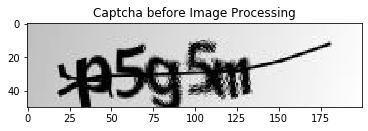

In [2]:
IMG_PATH="samples"
OUT_FOLDER="letters_from_captchas"

captchas = glob.glob(os.path.join(IMG_PATH, "*"))

x = []
y = []

for (i, path) in enumerate(captchas):
    
        #Get Captcha
        filename = os.path.basename(path)
        captcha_text = os.path.splitext(filename)[0] 
        captcha_img = cv.imread(path, cv.IMREAD_GRAYSCALE) 
        
        #Display example
        if i == 0:
            plt.title("Captcha before Image Processing")
            plt.imshow(captcha_img, 'gray')
            plt.plot()

        #Adaptive Threshold
        img = cv.adaptiveThreshold(captcha_img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 0)

        # Closing: Dilation followed by Erpsion
        img = cv.morphologyEx(img, cv.MORPH_CLOSE, np.ones((5, 2), np.uint8))

        #Dilation 
        img = cv.dilate(img, np.ones((2,2), np.uint8), iterations=1)

        #Bluring 
        img = cv.GaussianBlur(img, (1, 1), 0)
        
        #Captcha individual letters
        image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
        
        
        for i in range(5):
            x.append( img_to_array(Image.fromarray(image_list[i])))
            y.append( captcha_text[i] )
       
    
x = np.array(x) / 255
y = np.array(y)

Captcha after image processing


Text(0.5, 1.0, 'Character Distribution in CAPTCHAs')

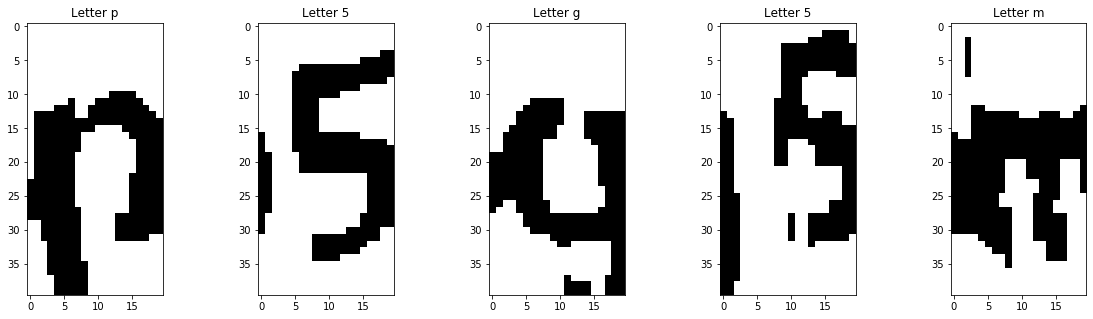

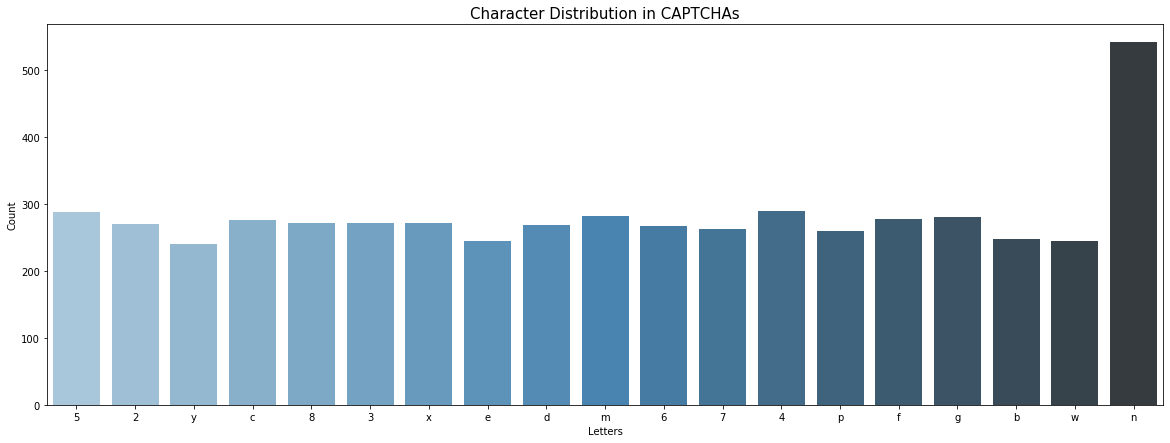

In [3]:
plt.figure(figsize = (20,5))
print("Captcha after image processing")
for i in range(0, 5) :
    plt.subplot(1,5,i+1)
    plt.imshow(x[i][:, :, 0], 'gray')  
    plt.title('Letter ' + str(y[i]))
plt.plot()

df = pandas.DataFrame({'Letters' : [c for c in set(y)],'Count' : [len(y[y==c]) for c in set(y)]})
plt.figure(figsize=(20,7))
seaborn.barplot(x='Letters', y='Count', data=df, palette="Blues_d")
plt.title("Character Distribution in CAPTCHAs", fontsize = 15) 

## <a class="anchor" id="one_hot">3 - One Hot Encoding</a>

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y_combine = LabelEncoder().fit_transform(y)
y_one_hot = OneHotEncoder(sparse = False).fit_transform(y_combine.reshape(len(y_combine),1))

letters = {y_combine[i] : y[i] for i in range(len(y))}

## <a class="anchor" id="train_test_split">3 - Train - Test Split</a>

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y_one_hot, test_size = 0.2, random_state=1)

x_test, x_validate, y_test, y_validate = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

## <a class="anchor" id="model">4 - Model</a>

In [6]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Input

In [7]:
def conv_layer (fltr) :
    
    model = Sequential()
    
    model.add(Conv2D(fltr, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same')) 
    
    return model

In [8]:
def dens_layer (fltr) :
    
    model = Sequential()
    
    model.add(Dense(fltr, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    return model

In [9]:
def cnn () :
    
    model = Sequential()
    model.add(Input((40, 20, 1,)))
    
    model.add(conv_layer( 64 ))
    model.add(conv_layer( 128 ))
    model.add(conv_layer( 256 ))
    model.add(conv_layer( 256 ))
    
    model.add(Flatten())
    model.add(dens_layer( 32 ))
    model.add(dens_layer( 32 ))
    
    model.add(Dense(19, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

## <a class="anchor" id="data_augmentation_and_supersampling">5 - Data Augmentation and Oversamplimg with SMOTE</a>

In [10]:
from imblearn.over_sampling import SMOTE

x_train = np.reshape(x_train, (x_train.shape[0], 40*20*1))

x_train, y_train = SMOTE(sampling_strategy = 'not majority', random_state = 1).fit_resample(x_train, y_train)

x_train = np.reshape(x_train, (x_train.shape[0], 40, 20, 1))

In [11]:
new_imgs = ImageDataGenerator(rotation_range = 25, width_shift_range = [-2,2])
new_imgs.fit(x_train)
train_set = new_imgs.flow(x_train, y_train, batch_size = 32)

## <a class="anchor" id="train">6 - Train</a>

In [12]:
model = cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 20, 10, 64)        896       
_________________________________________________________________
sequential_2 (Sequential)    (None, 10, 5, 128)        74368     
_________________________________________________________________
sequential_3 (Sequential)    (None, 5, 3, 256)         296192    
_________________________________________________________________
sequential_4 (Sequential)    (None, 3, 2, 256)         591104    
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 32)                49312     
_________________________________________________________________
sequential_6 (Sequential)    (None, 32)                1

## <a class="anchor" id="model_checkpoint">7 - ReduceLROnPlateau and Model Training</a>

In [13]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkp = ModelCheckpoint('./result_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)
reduce = ReduceLROnPlateau(patience = 20, verbose = 1)

In [14]:
#model.fit(x=train_set, validation_data=(x_validate, y_validate), epochs = 150, steps_per_epoch = len(x_train)/32, callbacks = [checkp, reduce]) #ionion

In [15]:
from keras.models import load_model

model = load_model('./result_model.h5')

In [16]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis = 1)

yres = np.argmax(y_test,axis= 1)

from sklearn.metrics import accuracy_score, classification_report

name = []
for i in sorted(letters):
    name.append(letters[i])

print('Accuracy : ' + str(accuracy_score(yres, pred)))
print(classification_report(yres, pred, target_names = name))

Accuracy : 0.8261682242990654
              precision    recall  f1-score   support

           2       0.88      0.95      0.91        22
           3       1.00      0.93      0.96        28
           4       0.96      0.92      0.94        26
           5       0.93      0.96      0.95        28
           6       0.89      0.94      0.92        36
           7       0.89      0.80      0.84        20
           8       0.85      0.85      0.85        26
           b       0.97      0.97      0.97        30
           c       0.84      0.88      0.86        24
           d       0.75      0.91      0.82        23
           e       1.00      0.94      0.97        32
           f       1.00      0.96      0.98        27
           g       0.91      0.91      0.91        23
           m       0.32      0.89      0.47        28
           n       0.40      0.04      0.07        53
           p       0.96      0.80      0.87        30
           w       0.87      0.93      0.90        

## <a class="anchor" id="knn">8 - KNN</a>

Text(0, 0.5, 'Testing Accuracy')

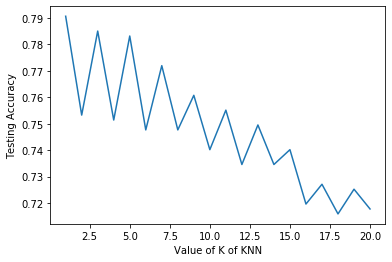

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#Running from k=1 through 20 and record testing accuracy and discovering best K
k_range = range(1,21)
scores = {}
scores_list = []
#Reshapping to make data compatible with KNN
x_train_knn = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
x_test_knn = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_knn, y_train)
    y_pred = knn.predict(x_test_knn)
    scores[k] = metrics.accuracy_score(y_test, y_pred)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))
plt.plot(k_range, scores_list)
plt.xlabel('Value of K of KNN')
plt.ylabel('Testing Accuracy')

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#Using n_neighbors = 1, best result in previous graph
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train_knn, y_train)
y_pred = knn.predict(x_test_knn)

In [19]:
from sklearn.metrics import classification_report

Accuracy = knn.score(x_test_knn, y_test)
print('KNN Accuracy: ', Accuracy)
print(classification_report(y_test, y_pred, target_names = name))

KNN Accuracy:  0.7906542056074767
              precision    recall  f1-score   support

           2       0.74      0.91      0.82        22
           3       0.89      0.86      0.87        28
           4       0.85      0.88      0.87        26
           5       0.85      0.82      0.84        28
           6       0.83      0.81      0.82        36
           7       0.80      0.80      0.80        20
           8       0.74      0.77      0.75        26
           b       1.00      0.93      0.97        30
           c       0.60      0.62      0.61        24
           d       0.72      0.78      0.75        23
           e       0.71      0.62      0.67        32
           f       0.86      0.93      0.89        27
           g       0.89      0.74      0.81        23
           m       0.50      0.50      0.50        28
           n       0.61      0.70      0.65        53
           p       0.85      0.73      0.79        30
           w       0.96      0.93      0.95    

## <a class="anchor" id="kfold">9 - K-Fold Validation</a>

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

ykfold = np.argmax(y_one_hot, axis = 1)
kf = KFold(n_splits=5, shuffle=True)
for train, test in kf.split(x):
    xkfoldTrain, xkfoldTest = x[train], x[test]
    ykfoldTrain, ykfoldTest = ykfold[train], ykfold[test]
    xkfoldTrainKNN = xkfoldTrain.reshape(xkfoldTrain.shape[0], xkfoldTrain.shape[1] * xkfoldTrain.shape[2] * xkfoldTrain.shape[3])
    xkfoltTestKNN = xkfoldTest.reshape(xkfoldTest.shape[0], xkfoldTest.shape[1] * xkfoldTest.shape[2] * xkfoldTest.shape[3])
    predictedTrain = knn.predict(xkfoldTrainKNN)
    predictedTrain2 = np.argmax(predictedTrain, axis = 1)
    predictedTest = knn.predict(xkfoltTestKNN)
    predictedTest2 = np.argmax(predictedTest, axis = 1)

    
    confusion_train = confusion_matrix(ykfoldTrain, predictedTrain2.reshape(len(predictedTrain2), 1))
    
    confusion_test = confusion_matrix(ykfoldTest, predictedTest2.reshape(len(predictedTest2),1))

## <a class="anchor" id="matrix">10 - Confusion Matrices</a>

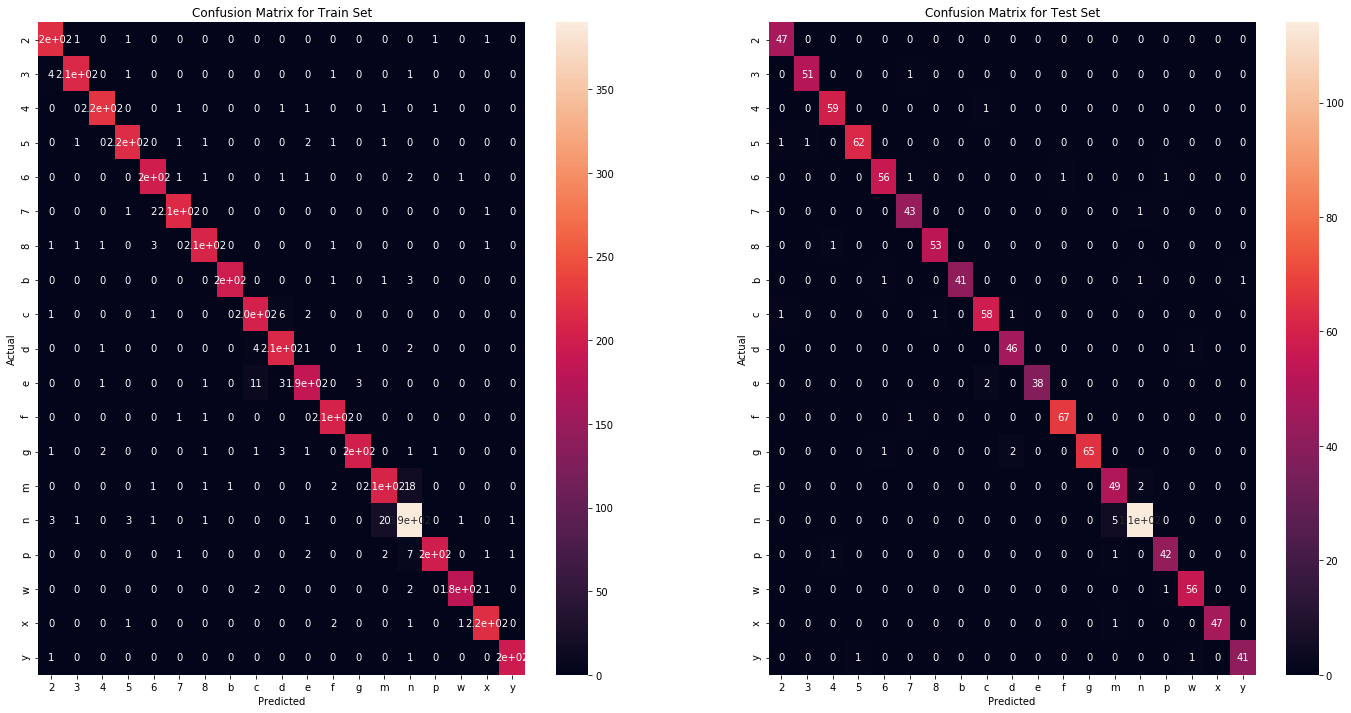

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
x_axis_labels = name
y_axis_labels = name
seaborn.heatmap(data=confusion_train, ax=ax1, annot=True, xticklabels = x_axis_labels, yticklabels = y_axis_labels)
seaborn.heatmap(data=confusion_test, ax=ax2, annot=True, xticklabels = x_axis_labels, yticklabels = y_axis_labels)
ax1.set_title("Confusion Matrix for Train Set")
ax2.set_title("Confusion Matrix for Test Set")
ax1.set_ylabel('Actual')
ax1.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')
plt.show()

## <a class="anchor" id="testing">11 - Testing Methods</a>

In [22]:
def testCaptchaKNN(imgPath):
    img = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]

    xdemo = []
    for i in range(5):
        xdemo.append(img_to_array(Image.fromarray(image_list[i])))
        
    xdemo = np.array(xdemo)
    xdemo /= 255.0
    xdemo_knn = xdemo.reshape(xdemo.shape[0], xdemo.shape[1] * xdemo.shape[2] * xdemo.shape[3])
    
    ydemo = knn.predict(xdemo_knn)
    ydemo = np.argmax(ydemo, axis = 1)
    captchaGuess = ""
    for res in ydemo:
        captchaGuess += letters[res]
    print("Captcha KNN Guess: " + captchaGuess)

In [23]:
def testCaptchaCNN(imgPath):
    model = load_model('./result_model.h5')
    img = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    xdemo = []
    for i in range(5):
        xdemo.append(img_to_array(Image.fromarray(image_list[i])))
        
    xdemo = np.array(xdemo)
    xdemo /= 255.0
    ydemo = model.predict(xdemo)
    ydemo = np.argmax(ydemo, axis = 1)
    
    captchaGuess = ""
    for res in ydemo:
        captchaGuess += letters[res]
    print("Captcha CNN Guess: " + captchaGuess)

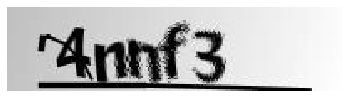

Captcha KNN Guess: 4mmf3


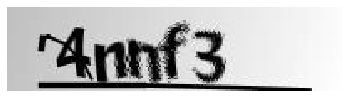

Captcha CNN Guess: 4mmf3


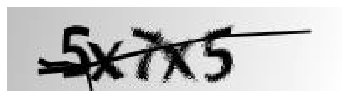

Captcha KNN Guess: 577x5


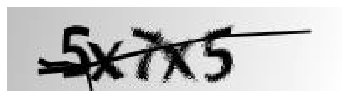

Captcha CNN Guess: 5e7x5


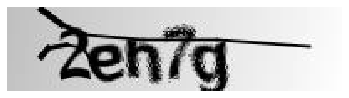

Captcha KNN Guess: 2em7g


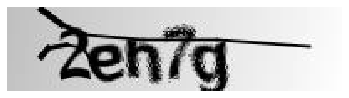

Captcha CNN Guess: 2en7g


In [24]:
testCaptchaKNN('samples/4nnf3.png')
testCaptchaCNN('samples/4nnf3.png')

testCaptchaKNN('samples/5x7x5.png')
testCaptchaCNN('samples/5x7x5.png')

testCaptchaKNN('samples/2en7g.png')
testCaptchaCNN('samples/2en7g.png')

In [25]:
def testAccuracyTreatedImage():
    IMG_PATH="samples"
    captchas = glob.glob(os.path.join(IMG_PATH, "*"))
    correctLetters = 0;
    correctCaptchas = 0;
    totalLetters = 0;
    totalCaptchas = 0;
    captchaGuess = ""
    model = load_model('./result_model.h5')
    for (i, path) in enumerate(captchas):
        filename = os.path.basename(path)
        nameString = str(filename)
        nameString = nameString[:-4]
        img = cv.imread(path, cv.IMREAD_GRAYSCALE)
        #Adaptive Threshold
        img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 0)

        # Closing: Dilation followed by Erpsion
        img = cv.morphologyEx(img, cv.MORPH_CLOSE, np.ones((5, 2), np.uint8))

        #Dilation 
        img = cv.dilate(img, np.ones((2,2), np.uint8), iterations=1)

        #Bluring 
        img = cv.GaussianBlur(img, (1, 1), 0)
        
        image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
        xdemo = []
        for i in range(5):
            xdemo.append(img_to_array(Image.fromarray(image_list[i])))
        xdemo = np.array(xdemo)
        xdemo /= 255.0
        ydemo = model.predict(xdemo)
        ydemo = np.argmax(ydemo, axis = 1)
        captchaGuess = ""
        for res in ydemo:
            captchaGuess += letters[res]
        if nameString == captchaGuess:
            correctCaptchas += 1;
        totalCaptchas += 1;
        for x, y in zip(nameString, captchaGuess):
            if x == y:
                correctLetters += 1
                totalLetters += 1
            else:
                totalLetters += 1
                
    lettersPercentage = correctLetters*100/totalLetters
    captchaPercentage = correctCaptchas*100/totalCaptchas
    print("Treated Image Results:")
    print("Correct Letters = ", correctLetters, " out of ",  totalLetters, ", having a ", lettersPercentage, "% accuracy!")
    print("Correct Captchas = ", correctCaptchas, " out of ", totalCaptchas, ", having a ", captchaPercentage, "% accuracy!")

In [26]:
def testAccuracyRealCaptcha():
    IMG_PATH="samples"
    captchas = glob.glob(os.path.join(IMG_PATH, "*"))
    correctLetters = 0;
    correctCaptchas = 0;
    totalLetters = 0;
    totalCaptchas = 0;
    captchaGuess = ""
    model = load_model('./result_model.h5')
    for (i, path) in enumerate(captchas):
        filename = os.path.basename(path)
        nameString = str(filename)
        nameString = nameString[:-4]
        img = cv.imread(path, cv.IMREAD_GRAYSCALE)
        image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
        xdemo = []
        for i in range(5):
            xdemo.append(img_to_array(Image.fromarray(image_list[i])))
        xdemo = np.array(xdemo)
        xdemo /= 255.0
        ydemo = model.predict(xdemo)
        ydemo = np.argmax(ydemo, axis = 1)
        captchaGuess = ""
        for res in ydemo:
            captchaGuess += letters[res]
        if nameString == captchaGuess:
            correctCaptchas += 1;
        totalCaptchas += 1;
        for x, y in zip(nameString, captchaGuess):
            if x == y:
                correctLetters += 1
                totalLetters += 1
            else:
                totalLetters += 1
                
    lettersPercentage = correctLetters*100/totalLetters
    captchaPercentage = correctCaptchas*100/totalCaptchas
    print("Non Treated Image Results:")
    print("Correct Letters = ", correctLetters, " out of ",  totalLetters, ", having a ", lettersPercentage, "% accuracy!")
    print("Correct Captchas = ", correctCaptchas, " out of ", totalCaptchas, ", having a ", captchaPercentage, "% accuracy!")
            

In [27]:
warnings.filterwarnings('ignore')
print()
testAccuracyTreatedImage()
testAccuracyRealCaptcha()


Treated Image Results:
Correct Letters =  4577  out of  5350 , having a  85.55140186915888 % accuracy!
Correct Captchas =  512  out of  1070 , having a  47.850467289719624 % accuracy!
Non Treated Image Results:
Correct Letters =  4328  out of  5350 , having a  80.89719626168224 % accuracy!
Correct Captchas =  404  out of  1070 , having a  37.757009345794394 % accuracy!


 ## <a class="anchor" id="DataProcTL">12 - Testing Second Approach for Data Processing and Transfer Learning</a>
 
 ### <a class="anchor" id="DataProcTL1"> 12.1 - Testing Second Approach for Data Processing
    
    From the book "Hands On Machine Learning for CyberSecurity"

In [28]:
from imutils import paths
from sklearn.preprocessing import LabelBinarizer


def resize_to_fit(image, width, height):
    
    (h, w) = image.shape[:2]
    
    image = cv.resize(image, (width, height))
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)
    
    image = cv.copyMakeBorder(image, padH, padH, padW, padW,
        cv.BORDER_REPLICATE)
    image = cv.resize(image, (width, height))
    
    return image

In [29]:
IMG_PATH="samples"
OUT_FOLDER="letters_from_captchas"
captchas = glob.glob(os.path.join(IMG_PATH, "*"))
counts={}
aux = 0

for (i, path) in enumerate(captchas):
    filename = os.path.basename(path)
    captcha_text = os.path.splitext(filename)[0] 
    captcha_img = cv.imread(path) 
    
    if captcha_img is not None:
        captcha_to_gray = cv.cvtColor(cv.imread(path) , cv.COLOR_BGR2GRAY) # convert BGR 2 GRAY
        captcha_to_gray = cv.copyMakeBorder(captcha_to_gray, 8, 8, 8, 8, cv.BORDER_REPLICATE) #extra padding
        captcha_threshold = cv.threshold(captcha_to_gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # convert blakc and white
        captcha_contours = cv.findContours(captcha_threshold.copy(),cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)[0]
        letter_image_regions = []
        
        for contour in captcha_contours:
            
            (x, y, w, h) = cv.boundingRect(contour) # Let (x,y) be the top-left coordinate of the rectangle and (w,h) be its width and height. 
            
            if w / h > 1.25: # This contour is too wide to be a single letter!   
                half_width = int(w / 2)    # Split it in half into two letter regions!
                if half_width / h < 1.25:
                    letter_image_regions.append((x, y, half_width, h))
                    letter_image_regions.append((x + half_width, y, half_width, h))
            
            else:  # This is a normal letter by itself
                letter_image_regions.append((x, y, w, h))
        
        if len(letter_image_regions) != 4:
            continue
        
        letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
        
        for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_text):
            x, y, w, h = letter_bounding_box
            letter_image = captcha_to_gray[y - 2:y + h + 2, x - 2:x + w + 2]
            save_path = os.path.join(OUT_FOLDER, letter_text)
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            count = counts.get(letter_text, 1)
            p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
            #print(letter_image.shape[0])
            if letter_image.shape[0] != 0 and letter_image.shape[1] != 0:
                if letter_image.shape[1] / letter_image.shape[0] < 2 and letter_image.shape[0] / letter_image.shape[1] > -2:
                    cv.imwrite(p, letter_image)
                    counts[letter_text] = count + 1
            aux += 1

In [30]:
LETTER_IMAGES_FOLDER = "letters_from_captchas"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"


# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv.imread(image_file)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Resize the letter so it fits in a 20x20 pixel box
    #print(image.shape)
    image = resize_to_fit(image, 20, 40)
    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]
    
    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

 ### <a class="anchor" id="DataProcTL2"> 12.2 - Transfer Learning

In [ ]:
from keras.models import load_model
from keras.models import Model

tl_model = load_model('./result_model.h5') 
tl_model.trainable = False # freeze 

inputs = Input((40, 20, 1))
x = tl_model(inputs, training=False)
outputs=Dense(19, activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 5, batch_size=15) 

Epoch 1/5
24/25 [===========================>..] - ETA: 0s - loss: 2.9477 - accuracy: 0.0624